**Particle Filter Algorithm**

1. (sim) initialise pokemon positions
2. get initial pokemon distance level and rankings
3. create random particles for each pokemon on radar
4. assign selection probabilities to each particle based on the respective distance levels and rankings of that pokemon
5. resample the particle population of each pokemon based on the selection probabilities obtained in step 4
6. calculate the weighed average location of target pokemon
7. start moving in the direction of the weighed average location of target pokemon
8. listen for distance level or ranking change events. On event, halt moving and:
    1. re-calculate particle selection probabilities of affected pokemon(s)
    2. resample the particle population of affected pokemon(s)
    3. re-calculate weighed average location of target pokemon
    4. start moving in the direction obtained in the previous step and resume listening for events
9. program terminates when the target pokemon is within zero-footprint distance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from scipy.stats import gennorm
from scipy.stats import gamma
%matplotlib inline

In [117]:
def generate_initial_coordinates(side_length=2000, n_pokemon=9):
    pokemons = {}
    for i in range(n_pokemon):
        pokemons[i] = (random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2))
    return pokemons

def distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# this is not visible to players
def pokemon_distances(player_coord, pokemons):
    return {i: distance(player_coord, coord) for i, coord in pokemons.items()}

# def particle_distances(player_coord, particles):
#     return [distance(player_coord, particle) for particle in particles]

def particle_distances(player_coord, particles):
    return np.sqrt(np.sum((player_coord - particles)**2, axis=1))

def rank(input):
    output = [0] * len(input)
    for i, x in enumerate(sorted(range(len(input)), key=lambda y: input[y])):
        output[x] = i
    return output

# player will be able to see this
def pokemon_rankings(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    rankings = {}
    for i, x in enumerate(sorted(range(len(dists)), key=lambda y: dists[y])):
        rankings[x] = i
    return rankings

def plot_pokemons(player_coord, pokemons):
    plt.figure(figsize=(15,15))
    # non-target pokemons
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][1:], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][1:])
    # target pokemon
    plt.scatter([x - player_coord[0] for x, y in [coord for coord in pokemons.values()]][0], 
                [y - player_coord[1] for x, y in [coord for coord in pokemons.values()]][0],
               marker="*", color='red', s=15)
    plt.axes().set_aspect(1)
    plt.axes().set_xlim((-1100, 1100))
    plt.axes().set_ylim((-1100, 1100))
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()
    
def footprint(distance):
    if distance < 10:
        return 0
    elif distance < 25:
        return 1
    elif distance < 100:
        return 2
    elif distance < 1000:
        return 3
    else:
        return 'invis'

def distance_levels(player_coord, pokemons):
    dists = pokemon_distances(player_coord, pokemons)
    return {i: footprint(v) for i,v in dists.items()}

def random_particle_generation(side_length=2000, n=1000):
    particles = np.ndarray((n, 2))
    for i in range(n):
        particles[i] = random.uniform(-side_length/2, side_length/2), random.uniform(-side_length/2, side_length/2)
    return particles

def plot_particles(player_coord, particles):
    plt.figure(figsize=(15,15))
    plt.scatter([p[0] - player_coord[0] for p in particles], 
                [p[1] - player_coord[1] for p in particles])
    plt.axes().set_aspect(1)
    plt.axes().set_xlim((-1100, 1100))
    plt.axes().set_ylim((-1100, 1100))
    # player
    plt.scatter(0, 0 , color='purple', s=15)
    # detection radii
    dists = {10:'green', 25:'blue', 100:'yellow', 1000:'red'}
    for r in dists:
        plt.axes().add_patch(plt.Circle((0,0), r, fill=False, color=dists[r]))
    plt.show()

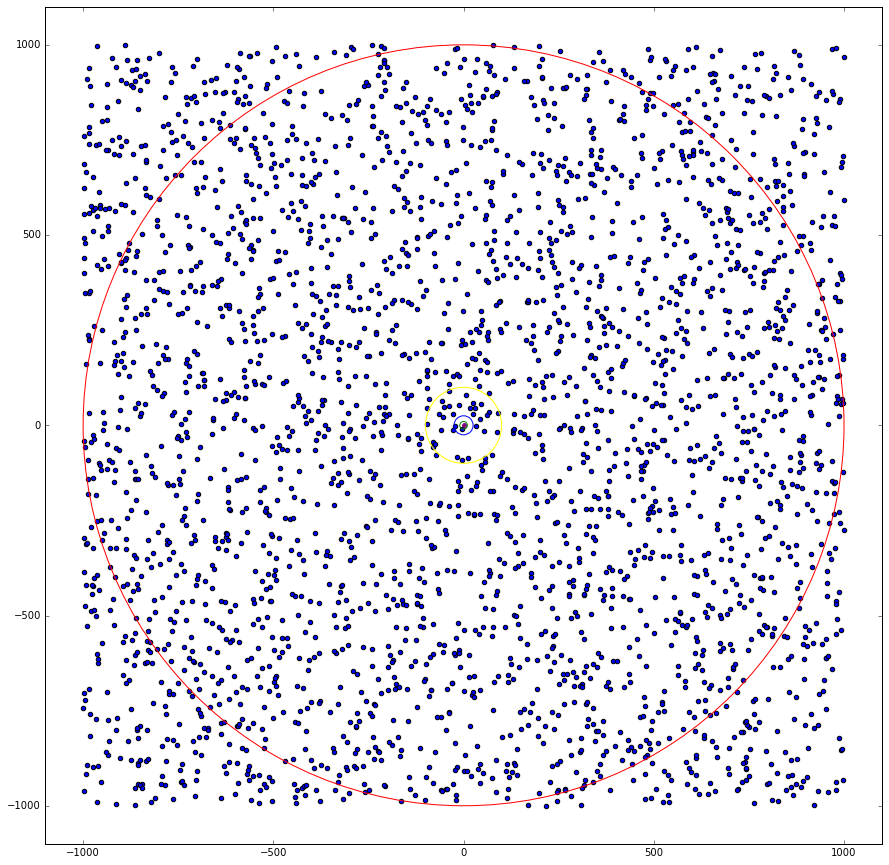

In [105]:
particles = random_particle_generation(n=3000)
plot_particles((0, 0), particles)

Another source of information we might want to exploit is the true ranking and probability of a particular particle being consistent with the ranking.

Let A, B denote two pokemons. Let A[i] denote a particle of pokemon A and B[j] a paricle of pokemon B. There are other pokemons C, D, E...

The probability that A[i] is consistent with a particular ranking (say B>A>C>...) is:

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C | B>A[i]) * P(A[i]>D | A[i]>C, B>A[i]) * ...

(Option 1) Using the naive approach, we have:

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C) * P(A[i]>D) * ...

(Option 2) Assuming the order of other particles are fixed, then the probability can be obtained by only considering immediately neighbouring pokemons, since the other conditional probabilities will be 1.

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C | B>A[i])

Now use the naive assumption:

    P(B>A[i] ^ A[i]>C ^ A[i]>D ^ ...) = P(B>A[i]) * P(A[i]>C)

We may calculate, say P(A[i]>C), as follows:

    P(A[i]>C) = sum{P(A[i]>C[j]) * P(C[j])} over all j

P(A[i]>C[j]) is either 1 or 0 depending on the relationship between the distance of A[i] and C[j].

So the probability of a particle being consistent with the true ranking is:

    L(A[i]) = sum{P(A[i]<B[j]) * P(B[j])} * sum{P(A[i]>C[j]) * P(C[j])}
    
Since all the B[j]'s and C[j]'s are already sampled according to their likelihood, we can assume that their densities in different locations already represent the probability of B at that location, and we can assume all P(B[j])'s and P(C[j])'s are equally likely. The expression can be further simplified as:

    L(A[i]) = sum{P(A[i]<B[j])} * sum{P(A[i]>C[j])}
   
Now we have a probability associated with each particle for a given pokemon with which we can perform the resampling.

Whenever an event occurs and the some particles are resampled, we can perform this operation on the particle populations to favour those particles that are more likely to be consistent with the ranking.

In [139]:
distributions = {
    0: lambda x: gennorm.pdf(x / 10, 3),
    1: lambda x: gennorm.pdf((x - 17.5) / 7.5, 3),
    2: lambda x: gennorm.pdf((x - 62.5) / 37.5, 4),
    3: lambda x: gennorm.pdf((x - 550) / 430, 6),
    'in': lambda x: gamma.pdf((-x + 1100) / (450/6), 1.5),
    'out': lambda x: gamma.pdf((x - 900) / (450/6), 1.5),
    'invis': np.vectorize(lambda x: 1)
}

# def resample_population(particles, particle_weights):
#     return [particles[np.random.choice(range(len(particles)), p=particle_weights / sum(particle_weights))] 
#             for i in range(len(particles))]

def resample_population(particles, particle_weights):
    return particles[np.random.choice(range(len(particles)), size=len(particles), p=particle_weights / sum(particle_weights))]

def resample_all_population(all_particles, all_particle_weights):
    return {i: particles[np.random.choice(range(len(particles)), size=len(particles), 
                                          p=all_particle_weights[i] / sum(all_particle_weights[i]))]
            for i, particles in all_particles.items()}

# def distance_level_weights(particle_distances, distance_level, distributions=distributions):
#     particle_weights = list(map(distributions[distance_level], particle_distances))
#     return particle_weights

def distance_level_weights(particle_distances, distance_level, distributions=distributions):
    return distributions[distance_level](particle_distances)

def all_distance_level_weights(all_particle_distances, all_distance_levels, distributions=distributions):
    return {i:distributions[all_distance_levels[i]](distances) for i, distances in all_particle_distances.items()}

def all_particle_distances(player_coord, all_particles):
    return {i: particle_distances(player_coord, v) for i,v in all_particles.items()}

def all_ranking_weights(all_particle_distances, rankings):
    # get sorted distances
    all_sorted_distances = {i: np.sort(distances) for i, distances in all_particle_distances.items()}
    # loop through all pokemons
    likelihoods = {}
    for i, distances in all_particle_distances.items():
        # select pokemons in neighbouring rankings
        selected_ranking = rankings[i]
        if selected_ranking == 0:
            prev_id = None
            next_id = next((k for k,v in rankings.items() if v == rankings[i] + 1))
        elif selected_ranking == len(rankings) - 1:
            next_id = None
            prev_id = next((k for k,v in rankings.items() if v == rankings[i] - 1))
        else:
            prev_id = next((k for k,v in rankings.items() if v == rankings[i] - 1))
            next_id = next((k for k,v in rankings.items() if v == rankings[i] + 1))
        # calculate weights for particle population
        if prev_id == None:
            prev_probs = 1
        else:
#             prev_probs = np.array([sum(a > all_particle_distances[prev_id]) for a in all_particle_distances[i]])
            prev_probs = np.searchsorted(all_sorted_distances[prev_id], all_particle_distances[i])
        if next_id == None:
            next_probs = 1
        else: 
#             next_probs = np.array([sum(a < all_particle_distances[next_id]) for a in all_particle_distances[i]])
            next_probs = len(distances) - np.searchsorted(all_sorted_distances[next_id], all_particle_distances[i])
        likelihoods[i] = prev_probs * next_probs
    return likelihoods

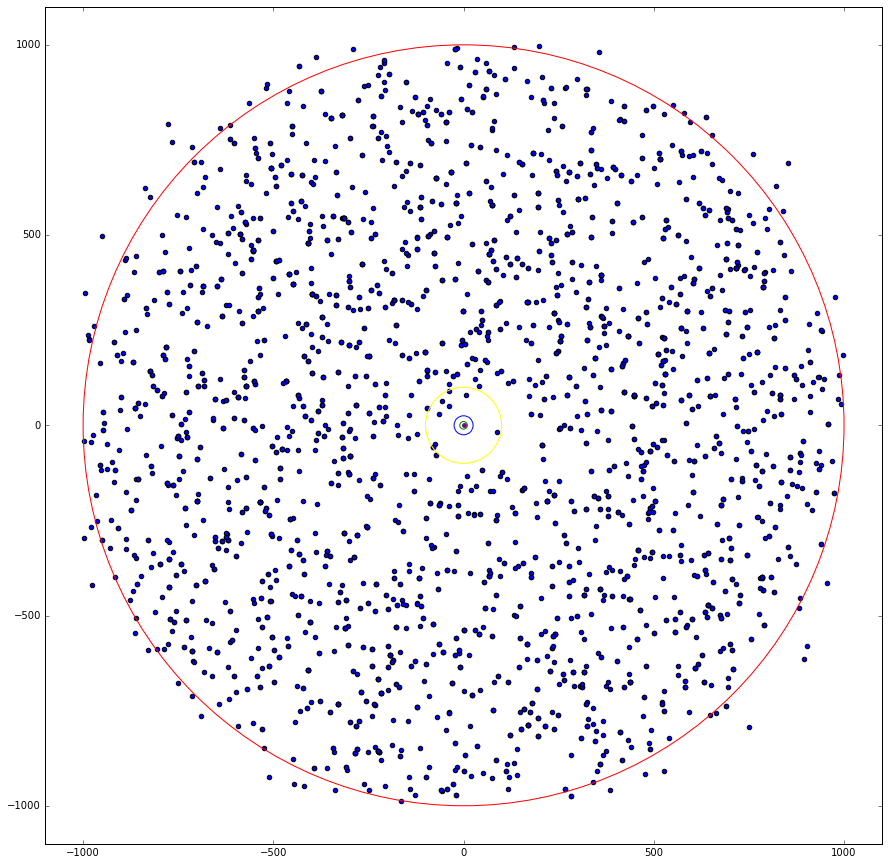

In [138]:
new_particles = resample_population(particles, distance_level_weights(particle_distances((0, 0), particles), 3))
plot_particles((0, 0), new_particles)

In [106]:
pokemons = generate_initial_coordinates()
pokemons

{0: (39.00896830979286, -510.1469049706031),
 1: (941.8005645919247, -60.18138412299322),
 2: (-145.1772450689583, -316.0952306984119),
 3: (376.70483464158724, -315.7752601777586),
 4: (-780.7557434681753, 146.30382527169286),
 5: (169.8657612969398, -487.1101390409665),
 6: (46.61138788139306, -589.2940161617003),
 7: (649.2632055959582, 805.4270702200113),
 8: (-730.6044404373282, -722.6882430665194)}

In [107]:
rankings = pokemon_rankings((0, 0), pokemons)
rankings

{0: 2, 1: 6, 2: 0, 3: 1, 4: 5, 5: 3, 6: 4, 7: 8, 8: 7}

In [108]:
all_particles = {i: random_particle_generation(n=3000) for i in range(len(pokemons))}
len(all_particles)

9

In [109]:
distances = all_particle_distances((0, 0), all_particles)
distances

{0: array([  496.11486101,   338.24925754,  1070.25336024, ...,  1068.66532032,
         1012.10442519,  1107.53308286]),
 1: array([  969.45951995,  1063.13380531,   891.8542354 , ...,   485.62236428,
          618.80517009,   567.67017195]),
 2: array([  881.72301288,  1065.13495229,  1213.22996121, ...,   645.10684429,
          381.92608522,   849.57483442]),
 3: array([  518.31365472,   898.50541667,   741.21365072, ...,  1024.20383768,
          899.17483926,   864.2189698 ]),
 4: array([ 1123.31899923,   422.9344649 ,   504.92068973, ...,   985.14136468,
          601.37334833,   348.72464926]),
 5: array([  814.29260887,   648.27078497,   542.52642192, ...,   777.30913797,
         1020.7446189 ,  1004.45381386]),
 6: array([  158.72085847,  1064.99923187,   595.19663028, ...,   524.70354398,
         1079.09360435,  1048.52858967]),
 7: array([ 1089.4566916 ,    80.50719228,   786.46471978, ...,   499.66411505,
          971.66676674,   506.63920219]),
 8: array([  891.9097456

In [110]:
all_ranking_weights(distances, rankings)

{0: array([1397494,  726180, 1073121, ..., 1084512, 1458054,  841031], dtype=int64),
 1: array([1767120, 1128600, 2204739, ..., 1399923, 1996620, 1763213], dtype=int64),
 2: array([1153,  402,  136, ..., 2011, 2660, 1281], dtype=int64),
 3: array([1413885, 2040310, 2073925, ..., 1339860, 2035648, 2118060], dtype=int64),
 4: array([ 875046, 1164933, 1485672, ..., 1706848, 1842094,  829311], dtype=int64),
 5: array([2236784, 1999000, 1648528, ..., 2262624, 1350870, 1472391], dtype=int64),
 6: array([ 188928, 1104675, 1727730, ..., 1512170, 1046800, 1180109], dtype=int64),
 7: array([2651,   11, 1435, ...,  561, 2215,  580], dtype=int64),
 8: array([2121119, 1914363, 1218140, ..., 2179872,  866904, 1816234], dtype=int64)}

In [122]:
levels = distance_levels((0, 0), pokemons)
levels

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 'invis', 8: 'invis'}

In [129]:
level_weights = all_distance_level_weights(distances, levels)
level_weights

{0: array([ 0.53895402,  0.53132479,  0.02340368, ...,  0.02477673,
         0.11549722,  0.00465679]),
 1: array([ 0.22769037,  0.03001793,  0.41869781, ...,  0.53895004,
         0.53894706,  0.5389561 ]),
 2: array([  4.36525849e-01,   2.80379692e-02,   7.65971620e-07, ...,
          5.38893013e-01,   5.37037568e-01,   4.80721483e-01]),
 3: array([ 0.53895602,  0.40593933,  0.53480486, ...,  0.08919701,
         0.40460911,  0.46283698]),
 4: array([ 0.0019578 ,  0.53859738,  0.53895539, ...,  0.18414348,
         0.53895454,  0.53331708]),
 5: array([ 0.51066837,  0.53887932,  0.53895611, ...,  0.52732251,
         0.09636627,  0.1337627 ]),
 6: array([ 0.30549899,  0.02816921,  0.53895538, ...,  0.53895608,
         0.01676336,  0.04752145]),
 7: array([1, 1, 1, ..., 1, 1, 1]),
 8: array([1, 1, 1, ..., 1, 1, 1])}

In [142]:
new_all_particles = resample_all_population(all_particles, level_weights)

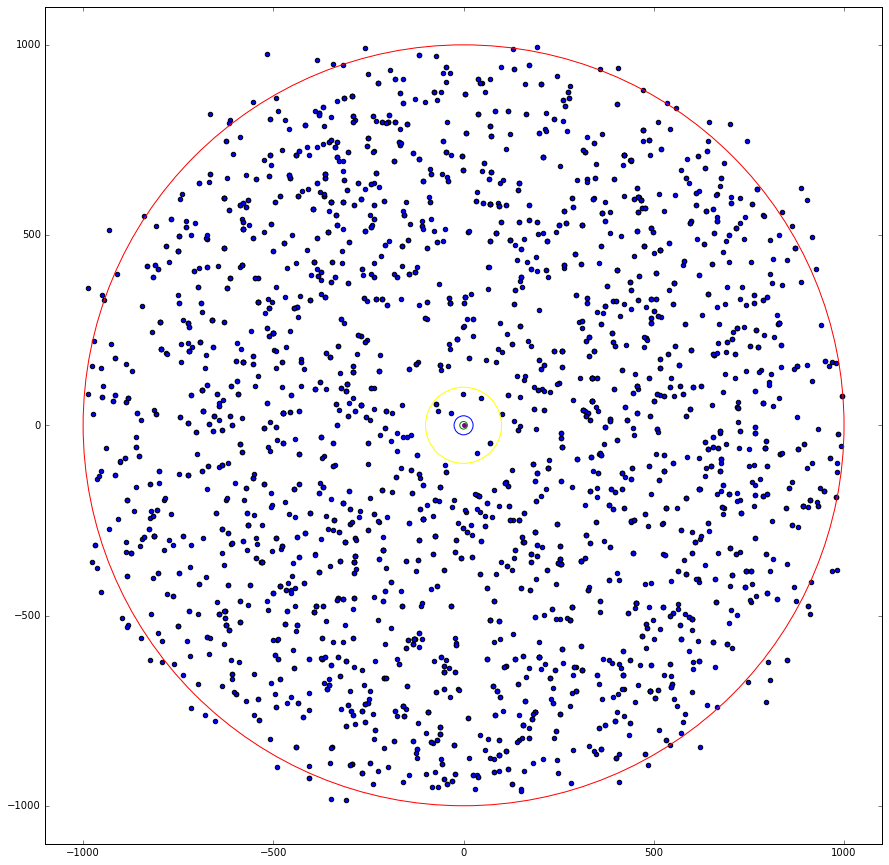

In [148]:
plot_particles((0, 0), new_all_particles[0])

In [149]:
# now we attempt two operations in a row
all_particles = {i: random_particle_generation(n=3000) for i in range(len(pokemons))}
distances = all_particle_distances((0, 0), all_particles)
level_weights = all_distance_level_weights(distances, levels)
new_all_particles = resample_all_population(all_particles, level_weights)
ranking_weights = all_ranking_weights(distances, rankings)
new_all_particles = resample_all_population(all_particles, ranking_weights)

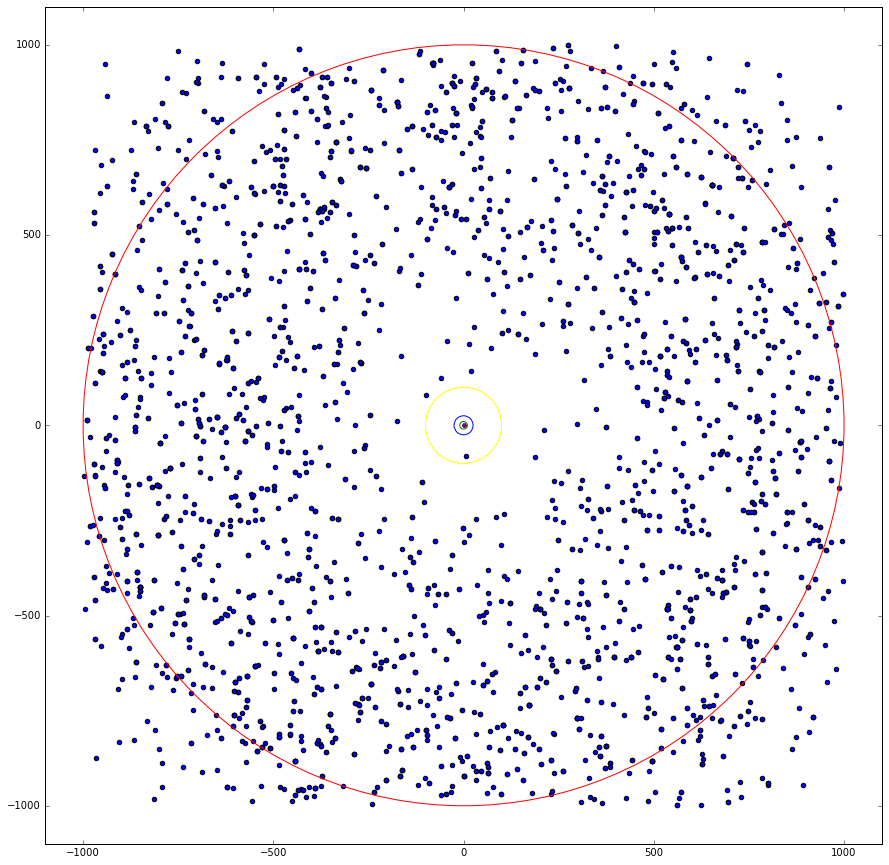

In [156]:
plot_particles((0, 0), new_all_particles[3])